<a href="https://colab.research.google.com/github/Ethn-Chn/M2-Baboon-Project/blob/main/Estimating_Chacma_baboon_population_characteristics_in_the_Garden_Route_National_Park_(South_Africa)_from_opportunistic_camera_trap_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
#pip install -r requirements.txt

In [9]:
# Packages & data import
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import geopandas as gpd
from scipy.spatial.distance import cdist
from geopy.distance import great_circle
import os
from matplotlib.offsetbox import AnchoredText
import imageio
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import re
import numpy as np

file_path = "data/"
Baboons = pd.read_excel(file_path + "Baboons.xlsx", header=0)
Baboons.head()

,Event ID,Station ID,Nb.photos / videos,Start,End,Event duration (h:mn:sec),Date,Station ID_1,Nb.ind,Nb.males,Nb.females,Nb.Adults,Nb.Subadults,Nb.Juvenils,Undetermined Adult,Activities,Mouvement,Comments,Photos/Vidéos,Other observations
0,5-7,5,4,11:05:29,11:07:20,00:01:00,2016-06-15,G4,28,5.0,8.0,16.0,8.0,4.0,3.0,Travelling,ND,NaN,Videos,NaN
1,5-10,5,2,11:31:19,11:31:52,00:00:00,2016-06-15,G4,25,5.0,7.0,18.0,5.0,2.0,6.0,Travelling,D,NaN,Videos,NaN
2,5-43,5,4,08:31:12,08:33:53,00:02:00,2016-06-22,G4,19,1.0,1.0,15.0,1.0,3.0,13.0,Rest; Food,S,NaN,Videos,NaN
3,9-4,9,16,09:50:02,09:52:25,00:02:00,2016-06-23,G10,8,1.0,0.0,6.0,0.0,2.0,5.0,Rest; Social,S,NaN,Photos,NaN
4,5-49,5,1,15:03:31,15:03:31,00:00:00,2016-06-24,G4,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,EMPTY,NaN,NaN


In [10]:
# Data manipulation
Baboons.columns = ["Event", "StationID", "Nbp", "Start", "End", "Eventd", "Date", "Station", "Ind", "Male", "Female", "Adult", "SubAdult",
                   "Juvenile", "UknA", "Activity", "Mouvement", "Comments", "Photo/Video", "Observation"]
# Supress NA
Baboons = Baboons[Baboons['Male'].notna()]

# Event by stations
events_per_station = Baboons['StationID'].value_counts().reset_index()
events_per_station.columns = ['Station ID', 'Number of Events']
events_per_station = events_per_station.sort_values(by='Number of Events', ascending=False)


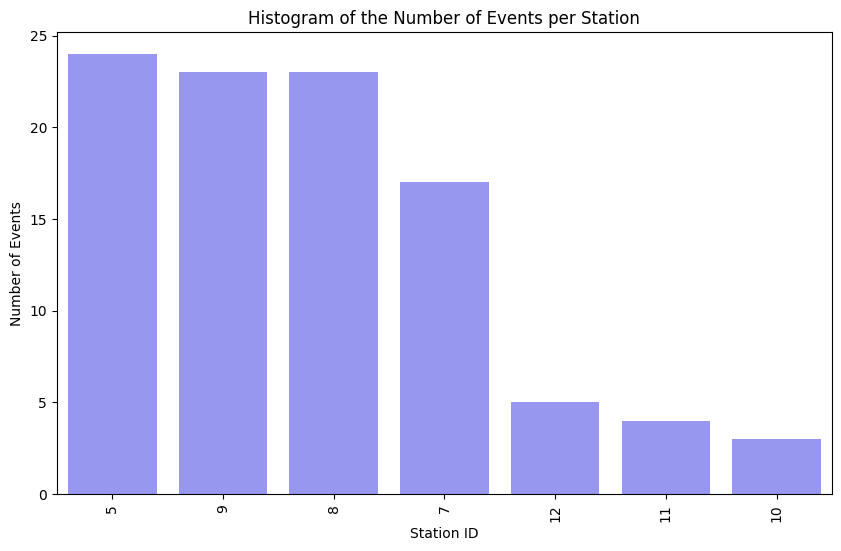

In [11]:
# Number of events per station histogram
plt.figure(figsize=(10, 6))
sns.barplot(x='Station ID', y='Number of Events', data=events_per_station, order=events_per_station['Station ID'],color="#8888ff")
plt.xticks(rotation=90)
plt.title("Histogram of the Number of Events per Station")
plt.xlabel("Station ID")
plt.ylabel("Number of Events")
plt.show()


In [12]:
# Reducing the dataset to columns of interest
Baboons2 = Baboons[['Event', 'Station', 'Date', 'Ind']].copy()

# YMD format for date and add of columns 'Year', 'Month', 'Day'
Baboons2['Date'] = pd.to_datetime(Baboons2['Date'])
Baboons2['Year'] = Baboons2['Date'].dt.year
Baboons2['Month'] = Baboons2['Date'].dt.month
Baboons2['Day'] = Baboons2['Date'].dt.day

# Column 'Week'
first_date = Baboons2['Date'].min()
Baboons2['Week'] = Baboons2['Date'].apply(lambda x: (x - first_date).days // 7)
Baboons2['Nbevent'] = 1
Baboons2 = Baboons2.sort_values(by='Date')

# Per day
by_day = Baboons2.groupby(['Station', 'Date']).size().unstack(fill_value=0)
# Per week
by_week = Baboons2.groupby(['Station', 'Week']).size().unstack(fill_value=0)
# Per month
Baboons2['Month_Year'] = Baboons2['Month'].astype(str) + "-" + Baboons2['Year'].astype(str)
by_month = Baboons2.groupby(['Station', 'Month_Year']).size().unstack(fill_value=0)
# Per year
by_year = Baboons2.groupby(['Station', 'Year']).size().unstack(fill_value=0)
by_year['Tot'] = by_year.sum(axis=1)

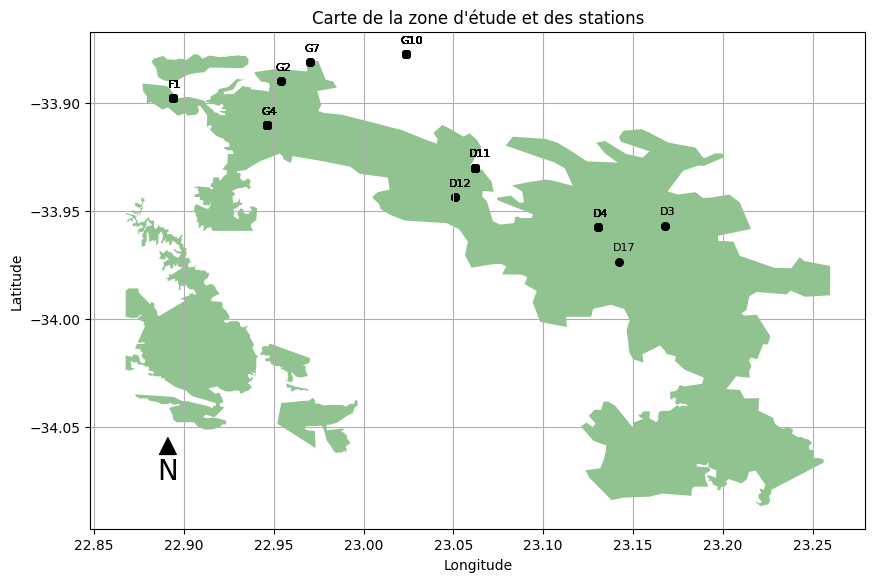

In [13]:
# Shapefile import
Stations = gpd.read_file(file_path + "QGIS_data/Stations.shp")
Terrain = gpd.read_file(file_path + "QGIS_data/Terrain.shp")

# Coordinates per station
coords = Stations.groupby('Stations').agg({'Latitude': 'mean', 'Longitude': 'mean'}).reset_index()
coords = coords.rename(columns={'Stations': 'Station'})
Stations = Stations[Stations['Nbevent'] != 0]
Stations.columns = ["ID", "Station_ID", "Date", "Nbevent", "Latitude", "Longitude", "geometry"]

# Distance calculation function
def calculate_distance(lat1, long1, lat2, long2):
    return great_circle((lat1, long1), (lat2, long2)).meters

# Map
fig, ax = plt.subplots(figsize=(10, 10))
Terrain.plot(ax=ax, alpha=0.5, color = "#228822")
Stations.plot(ax=ax, color='#000000', markersize=30)

# Labels for each stations
for x, y, label in zip(Stations.geometry.x, Stations.geometry.y, Stations['Station_ID']):
    ax.text(x - 0.003 , y + 0.005, label, fontsize=8)

ax.annotate('N', xy=(0.1, 0.185), xytext=(0.1, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            fontsize=20, ha='center')
ax.set_title("Carte de la zone d'étude et des stations")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True)

plt.show()

In [14]:
# Preparing data for the creation of the animated map
## Week
by_week_coords = pd.merge(by_week, coords, on = "Station")
by_week_coords.head()
by_week_combine = by_week_coords.melt(id_vars=['Station', 'Latitude', 'Longitude'],
                    var_name='semaine',
                    value_name='nombre_evenements')

by_month_coords =  pd.merge(by_month, coords, on = "Station")
by_month_combine = by_month_coords.melt(id_vars = ['Station', 'Latitude', 'Longitude'],
                    var_name='Month',
                    value_name='nombre_evenements')

by_month_combine['Month'] = pd.to_datetime(by_month_combine['Month'], format='%m-%Y')

## Month
mois_presents = by_month_combine['Month'].unique()
mois_presents.sort()
mois_presents = [pd.Timestamp(date).strftime('%B %Y') for date in mois_presents]


In [15]:
# Animated map
folder_name = 'Map_weeks' # File name where maps are saved

if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Weeks in data
semaines_presentes = by_week_combine['semaine'].unique()
semaines_presentes.sort()

# Graph for each week present in the data (some weeks have no events, therefore they are not included)
for week in semaines_presentes:
    fig, ax = plt.subplots(figsize=(12, 6))
    Terrain.plot(ax=ax, alpha=0.5, color="#228822")

    week_data = by_week_combine[by_week_combine['semaine'] == week]

    plt.scatter([], [], c="#FF0000", alpha=0.8, s=100, label="Avec événements")
    plt.scatter([], [], c="#000000", alpha=0.8, s=100, label="Sans événements")

    legend_text = "ID Station - Événements\n"
    for idx, row in week_data.iterrows():
        size = row['nombre_evenements'] * 20 + 20
        color = "#FF0000" if row['nombre_evenements'] > 0 else "#000000"
        plt.scatter(row['Longitude'], row['Latitude'], s=size, alpha=0.8, color=color)
        plt.text(row['Longitude'] - 0.005, row['Latitude']+ 0.004, row['Station'], horizontalalignment='right', verticalalignment='top', fontsize=9)

        legend_text += f"{row['Station']} - {row['nombre_evenements']}\n"

        # North arrow
        ax.annotate('N', xy=(0.1, 0.185), xytext=(0.1, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            fontsize=20, ha='center')

    # Legend
    anchored_text = AnchoredText(legend_text, loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)
    ax.add_artist(anchored_text)
    file_name = os.path.join(folder_name, f'week_{week}.png')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Carte des événements par station - Semaine {week}')
    plt.savefig(file_name)
    plt.close()

semaines_presentes = by_week_combine['semaine'].unique()
semaines_presentes.sort()
filenames = [os.path.join(folder_name, f'week_{week}.png') for week in semaines_presentes]


<ipython-input-16-d119713a66c1>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


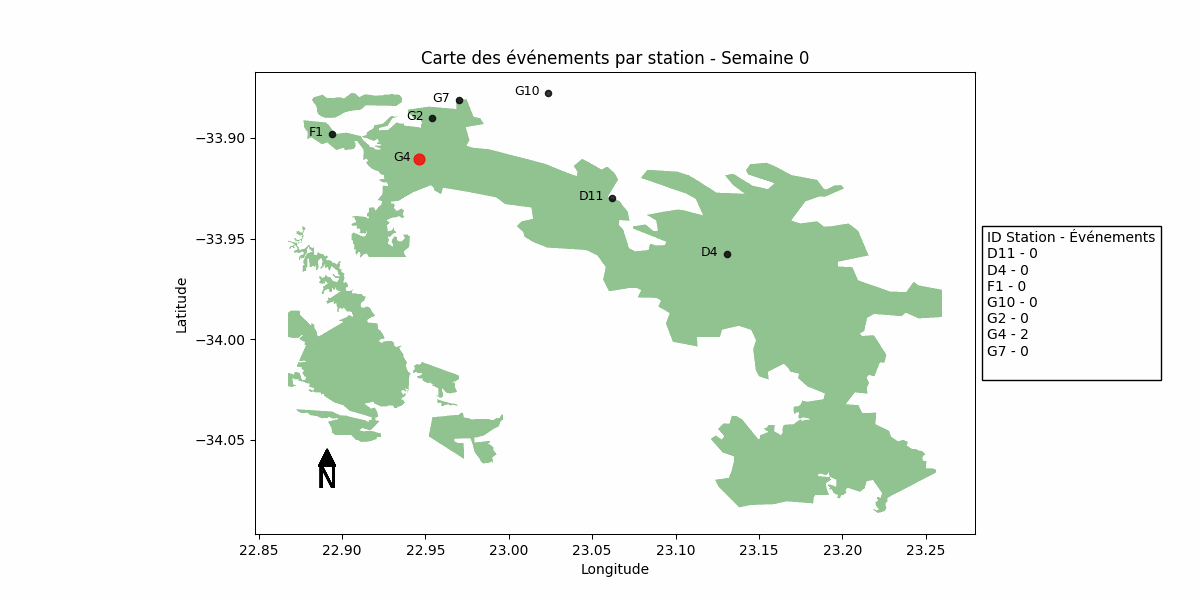

In [16]:
# Animation
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
gif_path = os.path.join(folder_name, 'animation.gif')
imageio.mimsave(gif_path, images, fps=2)

Image(filename=gif_path)

In [17]:
folder_name = 'Map_months' # File name where maps are saved

if not os.path.exists(folder_name):
    os.makedirs(folder_name)
# Graph for each month present in the data (like weeks some months have no events, therefore they are not included)
for month in mois_presents:
    fig, ax = plt.subplots(figsize=(12, 6))
    Terrain.plot(ax=ax, alpha=0.5, color="#228822")

    month_data = by_month_combine[by_month_combine['Month'] == month]

    plt.scatter([], [], c="#FF0000", alpha=0.8, s=100, label="Avec événements")
    plt.scatter([], [], c="#000000", alpha=0.8, s=100, label="Sans événements")

    legend_text = "ID Station - Événements\n"
    for idx, row in month_data.iterrows():
        size = row['nombre_evenements'] * 20 + 20
        color = "#FF0000" if row['nombre_evenements'] > 0 else "#000000"
        plt.scatter(row['Longitude'], row['Latitude'], s=size, alpha=0.8, color=color)
        plt.text(row['Longitude'] - 0.005, row['Latitude']+ 0.004, row['Station'], horizontalalignment='right', verticalalignment='top', fontsize=9)

        legend_text += f"{row['Station']} - {row['nombre_evenements']}\n"

        # North arrow
        ax.annotate('N', xy=(0.1, 0.185), xytext=(0.1, 0.1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            xycoords='axes fraction', textcoords='axes fraction',
            fontsize=20, ha='center')

    # Legend
    anchored_text = AnchoredText(legend_text, loc='center left', bbox_to_anchor=(1, 0.5), bbox_transform=ax.transAxes)
    ax.add_artist(anchored_text)
    file_name = os.path.join(folder_name, f'month_{month}.png')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Carte des événements par station - Mois {month}')
    plt.savefig(file_name)
    plt.close()

mois_presents_datetime = [datetime.strptime(date, '%B %Y') for date in mois_presents]
mois_presents_datetime.sort()
mois_presents_str = [datetime.strftime(date, '%B %Y') for date in mois_presents_datetime]

filenames = [os.path.join(folder_name, f'month_{month}.png') for month in mois_presents_str]



<ipython-input-18-92b631a0be74>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


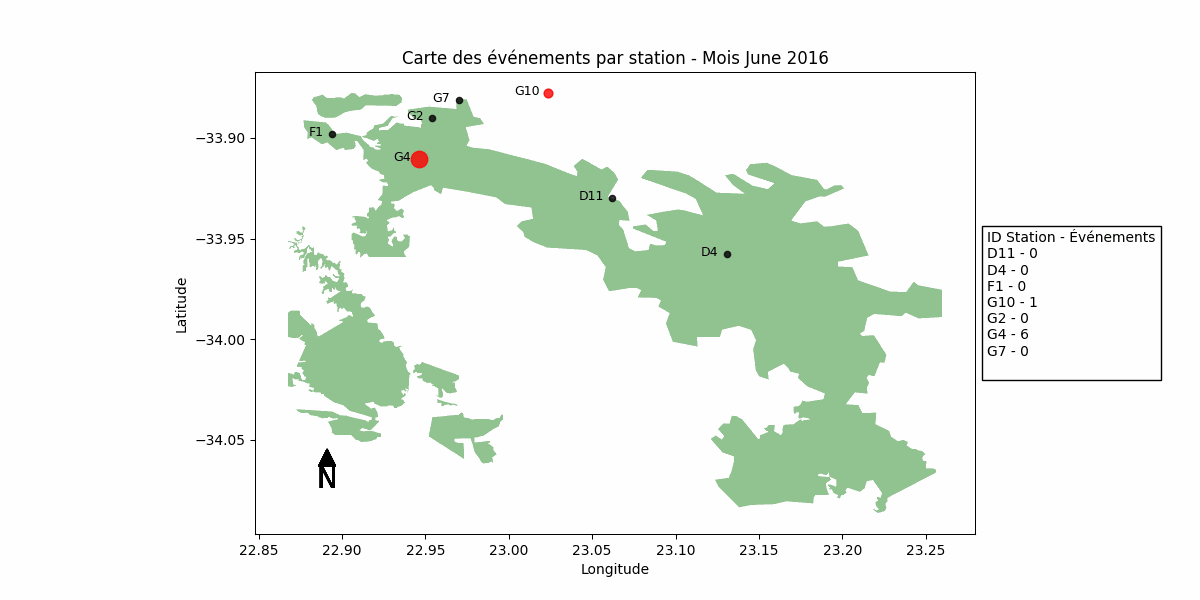

In [18]:
# Animation
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
gif_path = os.path.join(folder_name, 'animation.gif') # Gif path
imageio.mimsave(gif_path, images, fps=2)

Image(filename=gif_path)

In [19]:
# Spatial distances matrix
spatial_distances = pd.DataFrame(columns=['Event', 'Distance'])
Baboons.reset_index(drop=True, inplace=True)

for i in range(len(Baboons) - 1): # Loop through each event in Baboons data
    # Retrieve coords for the current and next event
    lat1 = coords.loc[coords['Station'] == Baboons.at[i, 'Station'], 'Latitude'].values[0]
    long1 = coords.loc[coords['Station'] == Baboons.at[i, 'Station'], 'Longitude'].values[0]
    lat2 = coords.loc[coords['Station'] == Baboons.at[i + 1, 'Station'], 'Latitude'].values[0]
    long2 = coords.loc[coords['Station'] == Baboons.at[i + 1, 'Station'], 'Longitude'].values[0]
    # Calculate the distance between two points
    distance = great_circle((lat1, long1), (lat2, long2)).meters
    # Add the calculated distance to the dataframe
    new_row = pd.DataFrame({'Event': [Baboons.at[i, 'Event']], 'Distance': [distance]})
    spatial_distances = pd.concat([spatial_distances, new_row], ignore_index=True)

# Function to extract time from datetime string
def extract_time(datetime_str):
    return pd.to_datetime(datetime_str).time().strftime('%H:%M:%S')

Baboons['Date'] = Baboons['Date'].astype(str)
Baboons['Start'] = Baboons['Start'].astype(str)
Baboons['End'] = Baboons['End'].astype(str)

Baboons['StartTime'] = pd.to_datetime(Baboons['Date'] + ' ' + Baboons['Start'].apply(extract_time))
Baboons['EndTime'] = pd.to_datetime(Baboons['Date'] + ' ' + Baboons['End'].apply(extract_time))

# DataFrame who store temporal distances
temporal_distances = pd.DataFrame(columns=['Event', 'TimeDiff'])

# Calculate the time distance between consecutive events
for i in range(len(Baboons) - 1):
    time1 = Baboons.at[i, 'EndTime']
    time2 = Baboons.at[i + 1, 'StartTime']
    timediff = (time2 - time1).total_seconds() / 60  # Difference en minutes
    new_row = pd.DataFrame({'Event': [Baboons.at[i, 'Event']], 'TimeDiff': [timediff]})
    temporal_distances = pd.concat([temporal_distances, new_row], ignore_index=True)

# Pairs of events
event_pairs = pd.DataFrame({
    'Event1': Baboons['Event'][:-1],
    'Event2': Baboons['Event'][1:],
    'SpatialDistance': spatial_distances['Distance'],
    'TemporalDistance': temporal_distances['TimeDiff']
})


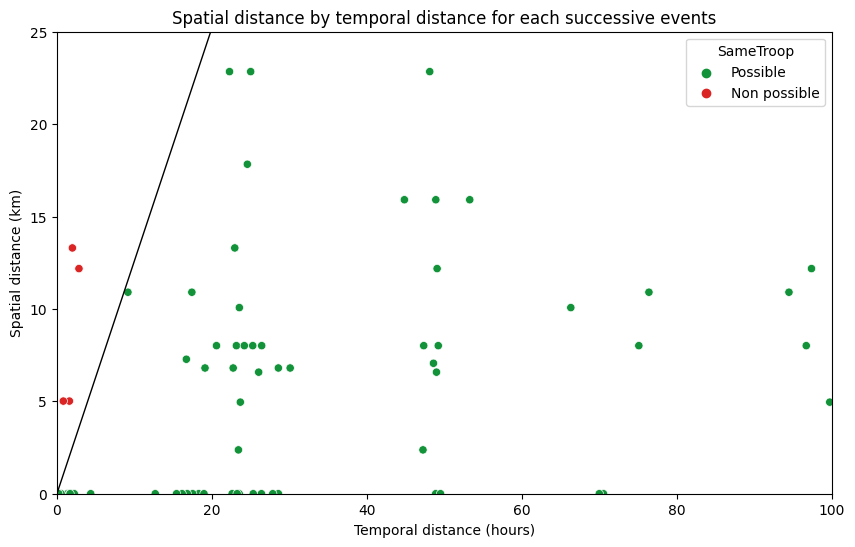

In [22]:
# Function to determine if consecutive events are trigerred by the same troop or not
def determine_same_troop(row):
    if row['SpatialDistance'] / 1000 <= row['TemporalDistance'] / 60 * 1.26:
        return "Possible"
    else:
        return "Non possible"
event_pairs['SameTroop'] = event_pairs.apply(determine_same_troop, axis=1)
palette = {"Possible" : "#139339", "Non possible" : "#DB2525"}
# Graph
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=event_pairs,
    x=event_pairs['TemporalDistance'] / 60,
    y=event_pairs['SpatialDistance'] / 1000,
    hue='SameTroop',
    palette=palette
)
# Reference line (represents the maximum movement speed of baboon troops, 1.26 km/h)
plt.axline((0, 0), slope=1.26, color="#000000", linewidth=1)
plt.xlim(0, 100)
plt.ylim(0, 25)
plt.xlabel("Temporal distance (hours)")
plt.ylabel("Spatial distance (km)")
plt.title("Spatial distance by temporal distance for each successive events")

plt.show()

Valeurs d'inertie pour différents k :
K=1: 297.0000000000001
K=2: 142.1914984087504
K=3: 83.36383304088577
K=4: 60.07484587439386
K=5: 46.98736985553729
K=6: 34.99504689383569
K=7: 27.982376773146008
K=8: 22.669574892711964
K=9: 18.81069227573962


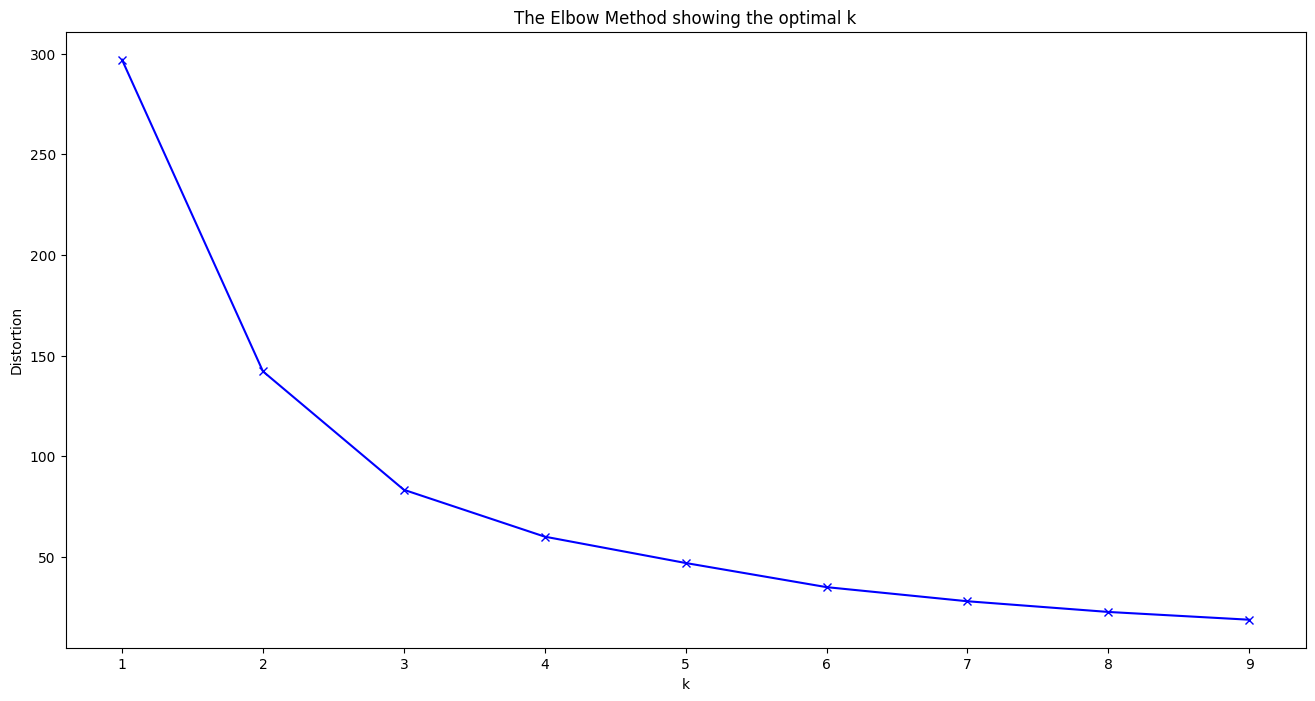

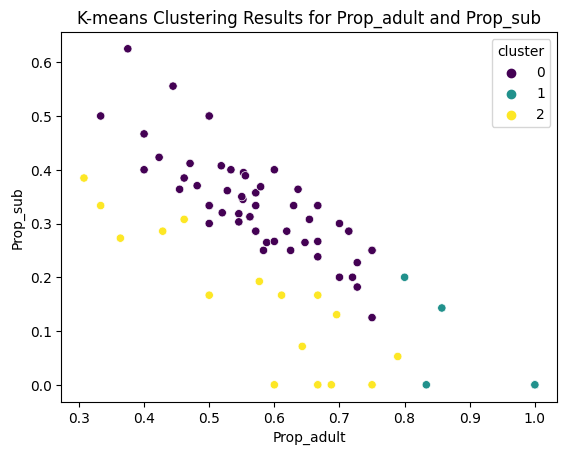

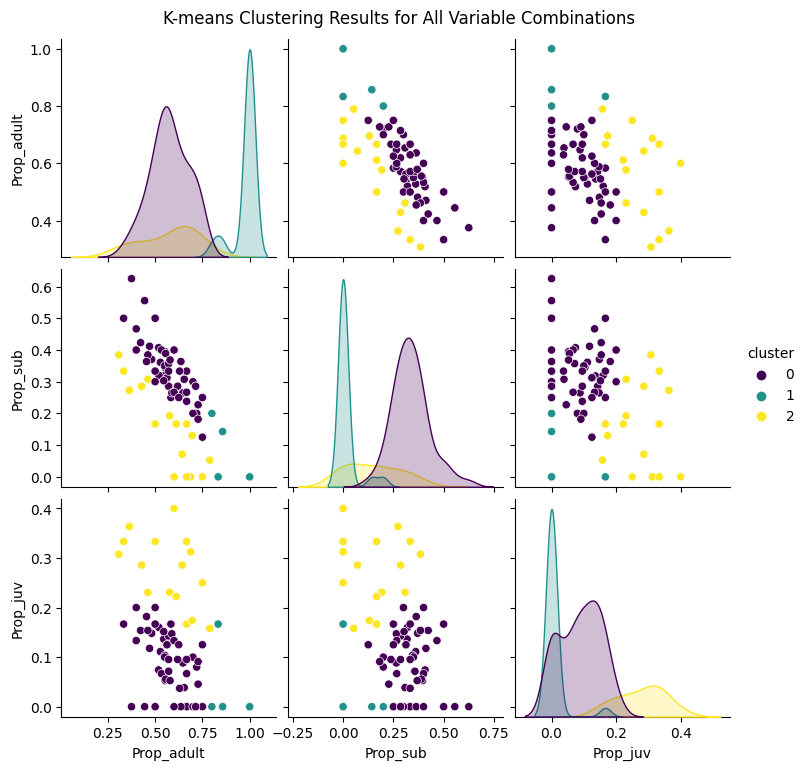

In [24]:
# Kmeans clustering
# Calculating proportions
Baboons['Prop_adult'] = Baboons['Adult'] / Baboons['Ind']
Baboons['Prop_sub'] = Baboons['SubAdult'] / Baboons['Ind']
Baboons['Prop_juv'] = Baboons['Juvenile'] / Baboons['Ind']

# Normalize data
Clustering_data = Baboons[['Prop_adult', 'Prop_sub', 'Prop_juv']]
scaler = StandardScaler()
Clustering_data = scaler.fit_transform(Clustering_data)

# ID events
Event_ID = Baboons['Event']

# Elbow method for differents K
distortions = []
K = range(1, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init = 10)
    kmeanModel.fit(Clustering_data)
    distortions.append(kmeanModel.inertia_)

print("Valeurs d'inertie pour différents k :")
for k, distortion in zip(K, distortions):
    print(f"K={k}: {distortion}")
# Elbow at K = 3

# Results
plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=123)
clusters = kmeans.fit_predict(Clustering_data)

# Clusters visualization
Baboons['cluster'] = clusters
sns.scatterplot(data=Baboons, x='Prop_adult', y='Prop_sub', hue='cluster', palette='viridis')
plt.title('K-means Clustering Results for Prop_adult and Prop_sub')
plt.show()

pair_plot = sns.pairplot(Baboons, vars=['Prop_adult', 'Prop_sub', 'Prop_juv'], hue='cluster', palette='viridis')
pair_plot.fig.suptitle('K-means Clustering Results for All Variable Combinations', y=1.02)
plt.show()
# Multiple peaks in density curve graphs, potentially indicating subgroups

In [26]:
# Baysian mod
def read_data(yobs_file, id_file):
    event_name = os.path.basename(yobs_file)
    event_name = re.sub("\.csv$", "", event_name)
    yobs = pd.read_csv(yobs_file, sep=";", header=0)
    ID = pd.read_csv(id_file, sep=";", header=0)
    return {"event_name": event_name, "yobs": yobs, "ID": ID}

# Data import (Allow to pair the correct event of CMR with his correct ID)
path = file_path + "CMR"
files = [f for f in os.listdir(path) if f.endswith('.csv')]
yobs = [f for f in files if not re.search("ID\\.csv$", f)]
print(yobs)
ID = [f for f in files if "ID.csv" in f]
print(ID)
pairs = []
for y_file in yobs:
    base_name = y_file.split('.')[0]  # Yobs file name
    id_file = base_name + "ID.csv"  # ID file name
    if id_file in ID:
        pairs.append({"yobs": os.path.join(path, y_file), "ID": os.path.join(path, id_file)})

all_data = [read_data(pair["yobs"], pair["ID"]) for pair in pairs]



['9-71.csv', '7-715.csv', '8-124b.csv', '12-608.csv', '7-658a.csv', '9-1801b.csv', '5-2221.csv', '7-685.csv', '5-291.csv', '9-1624.csv', '8-556.csv', '8-108.csv', '8-383.csv', '5-7.csv', '5-103.csv', '9-1629.csv', '7-716.csv', '7-689.csv', '8-457a.csv', '7-676.csv', '5-98.csv', '5-278.csv', '7-674.csv', '8-455.csv', '8-457b.csv', '9-1801a.csv', '7-658b.csv', '9-78.csv', '12-494.csv', '8-181.csv', '8-296.csv', '8-124a.csv']
['8-124aID.csv', '8-108ID.csv', '8-457bID.csv', '8-457aID.csv', '8-124bID.csv', '7-715ID.csv', '12-494ID.csv', '8-556ID.csv', '5-98ID.csv', '5-291ID.csv', '9-1624ID.csv', '7-674ID.csv', '5-7ID.csv', '5-278ID.csv', '9-1801bID.csv', '7-658bID.csv', '7-658aID.csv', '7-689ID.csv', '9-1801aID.csv', '5-103ID.csv', '12-608ID.csv', '8-383ID.csv', '9-78ID.csv', '9-1629ID.csv', '8-455ID.csv', '7-685ID.csv', '7-716ID.csv', '8-296ID.csv', '5-2221ID.csv', '9-71ID.csv', '8-181ID.csv', '7-676ID.csv']


In [27]:
for data in all_data:
    data["yobs"] = data["yobs"].iloc[:, 1:]
    # Age class transformation (Adult : 1, Subadult : 2, Juvenils : 3, Unknown : 1)
    data["ID"]["Class"] = data["ID"]["Class"].map({"A": "1", "S": "2", "J": "3", "U": "1"}).astype(str)

    # Data Augmentation
    IDaug = pd.DataFrame({
        "ID": range(0, 150),
        "Class": np.random.choice(["1", "2", "3"], 150, p=[0.6, 0.3, 0.1]),
        "Sex": ["U"] * 150
    })
    data["ID"] = pd.concat([data["ID"], IDaug], ignore_index=True)

    yAug = pd.DataFrame(np.zeros((150, data["yobs"].shape[1])), columns=data["yobs"].columns)
    data["yobs"] = pd.concat([data["yobs"], yAug], ignore_index=True)


In [ ]:
# Update system packages and install JAGS and PyJAGS for Bayesian analysis in a Jupyter notebook
!apt-get update
!apt-get install -y jags
!pip install pyjags
import pyjags

In [ ]:
model_string = """
model {
  # Priors
  omega ~ dunif(0, 1)  # Uniform prior for the probability an individual in the augmented population belongs to the true population N
  for (i in 1:3) {
    p[i] ~ dunif(0, 1)     # Uniform prior for the probability of capture if not previously captured
    c[i] ~ dunif(0, 1)     # Uniform prior for the probability of capture if previously captured
  }

  # Likelihood
  for (i in 1:M) {    # M is the number of rows in the data table (win.data)
    z[i] ~ dbern(omega)  # Bernoulli distribution for the indicator of whether an individual represents a real individual or not

    # First occasion
    yaug[i, 1] ~ dbern(p.eff[i, 1])  # Bernoulli distribution, p.eff[i, 1] for the probability of success
    p.eff[i, 1] <- z[i] * p[class[i]]

    # All subsequent occasions
    for (j in 2:T) {
      yaug[i, j] ~ dbern(p.eff[i, j])
      p.eff[i, j] <- z[i] * ((1 - yaug[i, (j-1)]) * p[class[i]] + yaug[i, (j-1)] * c[class[i]])
    } # j
  } # i

  # Derived quantities
  N <- sum(z)  # Total number of real individuals in the population
  for (i in 1:M) {
    y[i] <- step(1 - class[i])
    z1[i] <- z[i] * y[i]
    z3[i] <- z[i] * step(class[i] - 3)
  }
  N1 <- sum(z1) # Sum of individuals in class 1 (Adults)
  N3 <- sum(z3) # Sum of individuals in class 3 (Juvenils)
  N2 <- N - N1 - N3 # Number of individuals in class 2 (Subadults)
} # end model
"""

params = ["N", "p", "c", "omega", "N1", "N2", "N3"]
ni = 1000 # Nb of iterations
nt = 2 # Thinning interval (improve independance of samples)
nb = 500 # Burn-in, discard the first 500 iterations
nc = 3 # Nb of chains, 3 random initial values, allow to check the convergence of the MCMC algorithm

def initialize_model(M): # Initial values for z and p
    return {
        'z': np.ones(M, dtype=int).tolist(),
        'p': np.random.uniform(0, 1, 3).tolist()
    }
all_results = {}

# Running the JAGS model
for i in range(0,len(all_data)):
    class_col = all_data[i]["ID"]['Class']
    class_col = class_col.to_numpy().astype(str)
    yobs = all_data[i]["yobs"]
    yobs = yobs.to_numpy().astype(int)  # Convertit en entiers
    M, T = yobs.shape
    jags_data = {
        "yaug": yobs,
        "class": class_col,
        "M": M,
        "T": T
    }

    inits = [initialize_model(M) for _ in range(nc)]
    model = pyjags.Model(model_string, data=jags_data,init=inits, chains=nc)
    model.update(nb)
    samples = model.sample(ni, vars=params, thin=nt)
    results_summary = {var: np.mean(samples[var]) for var in samples}

    # Display results
    event_name = all_data[i]["event_name"]
    all_results[event_name] = results_summary

# Convert results into a Dataframe
all_results = pd.DataFrame(all_results)

In [30]:
all_results.to_csv('Bayesian_results.csv', index = True)

In [31]:
Bayesian_results = pd.read_csv('/content/Bayesian_results.csv')
print(Bayesian_results)

  Unnamed: 0       9-71      7-715     8-124b     12-608     7-658a  \
0          N  40.990000  13.444000  50.070667  75.343333  70.786000   
1         N1  28.366000   7.474000  28.856667  46.836667  43.655333   
2         N2  10.736000   3.818667  16.666000  22.882667  19.654000   
3         N3   1.888000   2.151333   4.548000   5.624000   7.476667   
4          c   0.747177   0.699133   0.773207   0.779984   0.478450   
5      omega   0.253079   0.088098   0.302595   0.419476   0.421963   
6          p   0.129343   0.487656   0.018470   0.015001   0.062996   

     9-1801b     5-2221      7-685       5-291  ...      7-674     8-455  \
0  33.598000  62.895333  22.914667  106.823333  ...  38.286667  4.913333   
1  20.833333  38.192000  13.738667   57.056000  ...  22.855333  4.579333   
2   9.988000  19.685333   4.816000   38.958000  ...  10.679333  0.303333   
3   2.776667   5.018000   4.360000   10.809333  ...   4.752000  0.030667   
4   0.951889   0.868177   0.740777    0.885693  ...